In [1]:
%matplotlib inline
from IPython.html.widgets import FloatProgress
from IPython.display import display

C:\Program Files\Anaconda2\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:

import gensim
import pandas as pd
import numpy as np
from sklearn.metrics import recall_score, make_scorer, confusion_matrix, precision_score
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt

from create_dictionary import train_corpus, transform_doc2bow, tokenize
from sklearn.metrics.pairwise import cosine_similarity

from online_lsi_sim import sim_two_lsi, sim_all_lsi
from online_lda_sim import sim_two_lda, sim_all_lda
from word2vec_sim import sim_two_w2v, sim_all_w2v
from doc_sim import sim_two, sim_all

from create_model import *


C:\Program Files\Anaconda2\lib\site-packages\gensim-0.13.3-py2.7-win-amd64.egg\gensim\utils.py:840: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Program Files\Anaconda2\lib\site-packages\gensim-0.13.3-py2.7-win-amd64.egg\gensim\utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")
C:\Program Files\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\gr

In [3]:

dictionary = gensim.corpora.Dictionary.load("../data/SESE.gz")
fname = "../SESE/cleaned/sql-html-sample.csv"

so_dat = pd.read_csv(fname)
so_dat_main = so_dat[['id', 'title', 'bodyString', 'tagsString']]

label_dat = pd.read_csv("../SESE/labels/sql-html-js-2_labels.csv")


# build each feature, and model
corpus = train_corpus(so_dat_main['bodyString'].tolist(), dictionary)

# all these models have online learning support
print "training lda..."
lda_mod = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=7, minimum_probability=0.0)
print "training lsi..."
lsi_mod = gensim.models.lsimodel.LsiModel(corpus, id2word=dictionary, num_topics=100)
print "training word2vec..."
w2v_mod = gensim.models.Word2Vec(min_count=5, sg=5)
sentences = [tokenize(x) for x in so_dat_main['bodyString'].tolist()]
w2v_mod.build_vocab(sentences )
w2v_mod.train(sentences)

training lda...
training lsi...
training word2vec...


227177

In [4]:

# do left join with labels.....
dat_combine = pd.merge(so_dat_main, label_dat)

# basically perform negative sampling to find weights to optimize these two cases....

# do stuff and output training dataset....(figure out how...)
# will be adhoc for future...

# train for recall..

# get the dups...
train = pd.read_csv("../SESE/cleaned/2016_link_dups_time_fix.csv")

In [5]:
def sim_query_all(single, docs, dictionary,
              lsi_mod, lda_mod, w2v_mod, prefix=""):
    """takes in two documents and computes similarity between
    both based on the models above, with all equal weights"""
    
    sim_vec = {'lsi': sim_all_lsi(single, docs, lsi_mod, dictionary).flatten().tolist(),
               'lda': sim_all_lda(single, docs, lda_mod, dictionary).flatten().tolist(), 
               'w2v': sim_all_w2v(single, docs, w2v_mod).flatten().tolist(), 
               'doc': sim_all(single, docs, dictionary).flatten().tolist()}
    df = pd.DataFrame(sim_vec)
    df.columns = [x+prefix for x in df.columns]
    return df

def sim_stackoverflow(single_dict, docs_df, columns, dictionary, 
                      lsi_mod, lda_mod, w2v_mod):
    """
    single_dict is a dictionary...
    
    docs_df is dataframe
    
    """
    
    #pd.concat([df1, df4], axis=1)
    if columns is None:
        columns = {'title': 'title', 
                   'body': 'bodyString', 
                   'tag': 'tagsString'}
    #print columns
    body_sim = sim_query_all(single_dict[columns['body']], docs_df[columns['body']].tolist(), 
                             dictionary, lsi_mod, lda_mod, w2v_mod, "_body")
    title_sim = sim_query_all(single_dict[columns['title']], docs_df[columns['title']].tolist(), 
                             dictionary, lsi_mod, lda_mod, w2v_mod, "_title")
    tag_sim = sim_query_all(single_dict[columns['tag']], docs_df[columns['tag']].tolist(), 
                             dictionary, lsi_mod, lda_mod, w2v_mod, "_tag")
    
    full_df = pd.concat([body_sim, title_sim, tag_sim], axis=1)
    return full_df

In [6]:
###

n_obs = 25
f = FloatProgress(min=0, max=n_obs-1)
display(f)

train_subset = train.iloc[:n_obs]
train_labels = train_subset[['id', 'did']]
train_labels.loc[:, 'label'] = 1

m_ids = sorted(train_subset['id'].tolist(), key=lambda x: int(x))
d_ids = sorted(train_subset['did'].tolist(), key=lambda x: int(x))

ddict = {'title': 'dtitle', 
        'body': 'dbodyString', 
        'tag': 'dtagsString'}
    
train_feats = []

for idx, m_id in enumerate(m_ids):
    f.value = idx
    train_temp = train_subset[train_subset['id'].astype(int) <= int(m_id)]
    # restack dataframe...
    dtrain_temp = train_temp[['dbodyString', 'dtagsString', 'dtitle', 'did']]
    dtrain_temp.columns = [x[1:] for x in dtrain_temp.columns]
    train_temp = train_temp[['id', 'title', 'bodyString', 'tagsString']]
    train_temp = pd.concat([train_temp, dtrain_temp])
    train_temp = train_temp[train_temp['id'] != m_id]
    single_doc = train_subset[train_subset['id'] == m_ids[0]].to_dict(orient="records")[0]
    temp_feats = sim_stackoverflow(single_doc, train_temp, None, dictionary,
              lsi_mod, lda_mod, w2v_mod)
    # input column and dup col - to infer id. 
    temp_feats.loc[:, 'id'] = m_id
    temp_feats.loc[:, 'did'] = train_temp['id'].tolist() 
    train_feats.append(temp_feats)
    




C:\Program Files\Anaconda2\lib\site-packages\pandas\core\indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Program Files\Anaconda2\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
feature_df = pd.merge(pd.concat(train_feats), train_labels, on=['id', 'did'], how='left').drop_duplicates()
feature_df.loc[:, 'label'] = feature_df['label'].fillna(0)
feature_df.describe()

,doc_body,lda_body,lsi_body,w2v_body,doc_title,lda_title,lsi_title,w2v_title,doc_tag,lda_tag,lsi_tag,w2v_tag,label
count,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000
mean,0.112915,0.301109,0.158275,0.934699,0.067345,0.256765,0.114219,0.861393,0.310540,0.259524,0.547464,0.856672,0.078400
std,0.189818,0.316288,0.198038,0.050624,0.214581,0.286520,0.268195,0.066718,0.265472,0.307823,0.392171,0.196892,0.269015
min,0.000000,0.016656,-0.055343,0.761848,0.000000,0.089186,-0.066210,0.652294,0.000000,0.096574,-0.082220,0.000000,0.000000
25%,0.025211,0.025841,0.046591,0.927748,0.000000,0.111537,-0.014362,0.805685,0.000000,0.102781,0.149296,0.837274,0.000000
50%,0.055057,0.125579,0.089400,0.951121,0.000000,0.139279,0.026831,0.860685,0.316228,0.125424,0.512976,0.928112,0.000000
75%,0.129206,0.468439,0.189108,0.969925,0.000000,0.152613,0.076694,0.911082,0.408248,0.152500,0.933392,0.957710,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
X = feature_df[[u'doc_body', u'lda_body', u'lsi_body', u'w2v_body', u'doc_title',
       u'lda_title', u'lsi_title', u'w2v_title', u'doc_tag', u'lda_tag',
       u'lsi_tag', u'w2v_tag']].as_matrix()
       
Y = feature_df[['label']].as_matrix().flatten()

In [9]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

clf.fit(X, Y)
#grid_search.predict(X)

print(confusion_matrix(Y, clf.predict(X)))
print(recall_score(Y, clf.predict(X)))

[[576   0]
 [ 14  35]]
0.714285714286


C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


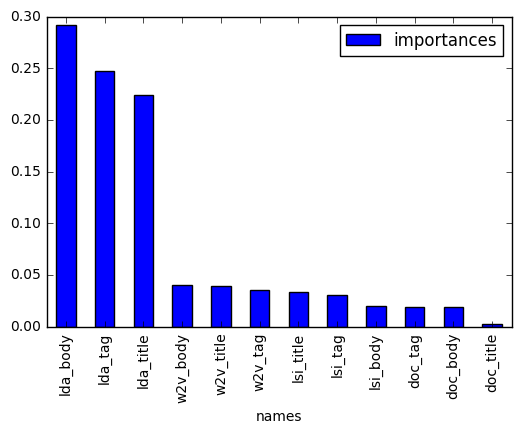

In [10]:
# build tree to see important feats?
feat_importance = clf.fit(X,Y).feature_importances_

feat_df = pd.DataFrame({
    'importances': feat_importance,
    'names': [u'doc_body', u'lda_body', u'lsi_body', u'w2v_body', u'doc_title',
       u'lda_title', u'lsi_title', u'w2v_title', u'doc_tag', u'lda_tag',
       u'lsi_tag', u'w2v_tag']
                        })
feat_df = feat_df.sort(['importances'], ascending=False)
feat_df.plot.bar(x="names", y="importances")